In [1]:
from google.colab import drive
drive.mount('/content/drive')
drivloc = "/content/drive/My Drive/DLProj2/CycleGAN/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!git clone https://www.github.com/keras-team/keras-contrib.git
!cd keras-contrib
!pip install git+https://www.github.com/keras-team/keras-contrib.git 

Cloning into 'keras-contrib'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3628 (delta 2), reused 1 (delta 0), pack-reused 3622
Receiving objects: 100% (3628/3628), 861.55 KiB | 1.87 MiB/s, done.
Resolving deltas: 100% (2324/2324), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-2jugikv5
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-2jugikv5
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=00838172cc6ccef9d5f7d17237919f8171b06fc9f44a9ae73859291ceb362159
  Stored in directory: /tmp/pip-ephem-wheel-cache-82y27n2x/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


######**References**


In [0]:
https://machinelearningmastery.com/cyclegan-tutorial-with-keras/
https://github.com/ImagingLab/Colorizing-with-GANs
https://medium.com/the-downlinq/artificial-colorization-of-grayscale-satellite-imagery-via-gans-part-1-79c8d137e97b

In [0]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from keras.datasets import cifar10
import numpy as np

In [0]:
# convert from color image (RGB) to grayscale
# source: opencv.org
def rgb2gray(rgb):
	return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])
 
#prepare training images from cifar10 dataset which are coloured and grayscale
def prepare_training_set():
	# load the CIFAR10 data
	(x_train, _), (x_test, _) = cifar10.load_data()
	img_rows = x_train.shape[1]
	img_cols = x_train.shape[2]
	channels = x_train.shape[3]
	X1 = x_train
	X2 = rgb2gray(x_train)
    #converting images from [0:255] to [0:1]
	X1 = X1.astype('float32') / 255
	X2 = X2.astype('float32') / 255
	# reshape images to row x col x channel for CNN output/validation
	X1 = X1.reshape(X1.shape[0], img_rows, img_cols, channels)
	X2 = X2.reshape(X2.shape[0], img_rows, img_cols, 1)
	return [X2,X1]

In [9]:
# load image data
dataset = prepare_training_set()
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
source_shape = dataset[0].shape[1:]
target_shape = dataset[1].shape[1:]
print(source_shape)

170500096/170498071 [==============================] - 6s 0us/step
Loaded (50000, 32, 32, 1) (50000, 32, 32, 3)
(32, 32, 1)


In [11]:
# define the discriminator model
def define_discriminator(image_shape):
	# source image input
	in_image = Input(shape=image_shape)
	# C32
	d = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C64
	d = Conv2D(64, (3,3), strides=(2,2), padding='same')(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (3,3), strides=(2,2), padding='same')(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer 256
	d = Conv2D(256, (3,3), padding='same')(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (3,3), padding='same')(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5]) #different
	print(model.summary())
	return model
	
d_model_A = define_discriminator(source_shape)
d_model_B = define_discriminator(target_shape)

# define the standalone generator model
def define_generator(image_shape, output_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	channels = int(output_shape[-1])
	e1 = Conv2D(32, (3,3), padding='same', kernel_initializer=init)(in_image)
	e1 = InstanceNormalization(axis=-1)(e1)
	e1 = LeakyReLU(alpha=0.2)(e1)
	# c7s1-64
	e2 = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e1)
	e2 = InstanceNormalization(axis=-1)(e2)
	e2 = LeakyReLU(alpha=0.2)(e2)
	# d128
	e3 = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e2)
	e3 = InstanceNormalization(axis=-1)(e3)
	e3 = LeakyReLU(alpha=0.2)(e3)
	# d256
	e4 = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e3)
	e4 = InstanceNormalization(axis=-1)(e4)
	e4 = LeakyReLU(alpha=0.2)(e4)
	# u128
	d1 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e4)
	d1 = Concatenate()([d1, e3])
	d1 = InstanceNormalization(axis=-1)(d1)
	d1 = LeakyReLU(alpha=0.2)(d1)
	# u64
	d2 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d1)
	d2 = Concatenate()([d2, e2])
	d2 = InstanceNormalization(axis=-1)(d2)
	d2 = LeakyReLU(alpha=0.2)(d2)
	#u32
	d3 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d2)
	d3 = Concatenate()([d3, e1])
	d3 = InstanceNormalization(axis=-1)(d3)
	d3 = LeakyReLU(alpha=0.2)(d3)
	# c7s1-3
	d4 = Conv2DTranspose(channels, (3,3), padding='same', kernel_initializer=init)(d3)
	d4 = InstanceNormalization(axis=-1)(d4)
	out_image = Activation('sigmoid')(d4)
	# define model
	model = Model(in_image, out_image)
	print(model.summary())
	return model
g_model_AtoB = define_generator(source_shape,target_shape)
g_model_BtoA = define_generator(target_shape,source_shape)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 32)        320       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
instance_normalization_23 (I (None, 8, 8, 64)          128       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 4, 128)         7385

In [0]:
# generate samples and save as a plot and save the model
def Plot_Images(step, g_model, trainX, trainY, name, flag, n_samples=5):
	# select a sample of input images
	ix = randint(0, trainX.shape[0], n_samples)
	X_in = trainX[ix]
	Y = trainY[ix]
	X_out, _ = create_generated_samples(g_model, X_in, 0)
   
	# # scale all pixels from [-1,1] to [0,1]
	# X_in = (X_in + 1) / 2.0
	# X_out = (X_out + 1) / 2.0
	# Y = (Y+1)/2.0
   
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		if flag:
			img = X_in[i].reshape(32,32)
			pyplot.imshow(img, interpolation='none', cmap='gray')
		else:
			pyplot.imshow(X_in[i])

	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		if flag:
			pyplot.imshow(X_out[i])
		else:
			img = X_out[i].reshape(32,32)
			pyplot.imshow(img, interpolation='none', cmap='gray')
   
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + 2*n_samples + i)
		pyplot.axis('off')
		if flag:
			img = Y[i]
			pyplot.imshow(img)
		else:
			img = Y[i]
			img = img.reshape(32,32)
			pyplot.imshow(img, interpolation='none', cmap='gray')
   
	# save plot to file
	filename1 = drivloc + '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.show()
	pyplot.savefig(filename1)
	pyplot.close()

def save(gan, generator1, generator2, discriminator, name):
    discriminator.trainable = False
    generator2.trainable = False
    filename1 = drivloc + 'gan' + name
    gan.save(filename1, include_optimizer=True)
    discriminator.trainable = True
    generator2.trainable = True
    filename1 = drivloc + 'g' + name
    generator1.save(filename1)
    filename1 = drivloc + 'd' + name
    discriminator.save(filename1)
    print('Saved: Models ')

from keras.models import load_model
def load_all_models(name):
    cust = {'InstanceNormalization': InstanceNormalization}
    # gan = pickle.load(open(drivloc + 'gan' + name, 'rb'), cust)
    gan = load_model(drivloc + 'gan' + name, cust, compile=False)
    gan.summary()
    discriminator = load_model(drivloc + 'd' + name, cust)
    generator = load_model(drivloc + 'g' + name, cust)
    discriminator.summary()
    generator.summary()

In [17]:
# Referred to 'https://machinelearningmastery.com/cyclegan-tutorial-with-keras/'
# select a batch of random samples, returns images and target
def create_samples(dataset, n_samples, patch_shape):
	y = ones((n_samples, patch_shape, patch_shape, 1)) # generate ones to match the size of patch gan
	return dataset[randint(0, dataset.shape[0], n_samples)], y #choose random instances

# generate a batch of images, returns images and targets
def create_generated_samples(g_model, dataset, patch_shape):
	y = zeros((len(dataset), patch_shape, patch_shape, 1))
	return g_model.predict(dataset), y  # generate fake instance based on generator_from_ATOB/BTOA

# define a composite model for updating generators by adversarial and cycle loss
def create_CyleGan(g_model_1, d_model, g_model_2, source_shape, target_shape):
	# corresponding generator is made trainable and rest all sub models are marked untrainable
	g_model_1.trainable = True
	d_model.trainable = False
	g_model_2.trainable = False
	# discriminator loss - adversarial loss
	input_gen = Input(shape=source_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# forward cycle - cycle consistency loss
	output_f = g_model_2(gen1_out)
	# backward cycle - cycle consistency loss
	input_id = Input(shape=target_shape)
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_f, output_b])
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae'], loss_weights=[1, 10, 10], optimizer=Adam(lr=0.0002, beta_1=0.5))
	print(model.summary())
	return model

c_model_AtoB = create_CyleGan(g_model_AtoB, d_model_B, g_model_BtoA, source_shape, target_shape)
c_model_BtoA = create_CyleGan(g_model_BtoA, d_model_A, g_model_AtoB, target_shape, source_shape)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 32, 32, 3)    870889      input_13[0][0]                   
                                                                 model_8[6][0]                    
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_8 (Model)                 (None, 32, 32, 1)    870307      model_7[5][0]             

In [0]:
def train_composite_model(batch_size):
    trainA, trainB = dataset
    n_patch = d_model_A.output_shape[1]
    X_realA, y_realA = create_samples(trainA, batch_size, n_patch)#create samples from grayscale images
    X_realB, y_realB = create_samples(trainB, batch_size, n_patch)#create samples from coloured images
    X_fakeA, y_fakeA = create_generated_samples(g_model_BtoA, X_realB, n_patch)#create grayscale samples from generatorAtoB
    X_fakeB, y_fakeB = create_generated_samples(g_model_AtoB, X_realA, n_patch)#create coloured samples from generatorBtoA
    val = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realB, X_realA])
    generator_loss_BtoA = val[0] 
    disc_lossA1 = d_model_A.train_on_batch(X_realA, y_realA)
    disc_lossA2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
    val = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realA, X_realB])
    generator_loss_AtoB = val[0]
    disc_lossB1 = d_model_B.train_on_batch(X_realB, y_realB)
    disc_lossB2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
    print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, disc_lossA1,disc_lossA2, disc_lossB1,disc_lossB2, generator_loss_BtoA,generator_loss_AtoB))

In [0]:
epochs = 100
batch_size=50
trainA, trainB = dataset
poolA, poolB = list(), list()
bat_per_epo = int(len(trainA) / batch_size)
# manually enumerate epochs
for i in range(bat_per_epo * epochs):
	train_composite_model(batch_size)
	# evaluate the model performance every so often
	if (i+1) % (5000) == 0:
		Plot_Images(i, g_model_AtoB, trainA,trainB, 'AtoB', True)
		Plot_Images(i, g_model_BtoA, trainB,trainA, 'BtoA', False)
		save(c_model_AtoB, g_model_AtoB, g_model_BtoA, d_model_B, '_model_AtoB_%06d.h5' % (i+1))
		save(c_model_BtoA, g_model_BtoA, g_model_AtoB, d_model_A, '_model_BtoA_%06d.h5' % (i+1))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


#Load the Trained Model and Generate Images

In [0]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from keras.datasets import cifar10
import numpy as np
from keras.models import load_model

drivloc = ""
def load_all_models(name):
    cust = {'InstanceNormalization': InstanceNormalization}
    # gan = pickle.load(open(drivloc + 'gan' + name, 'rb'), cust)
    # gan = load_model(drivloc + 'gan' + name, cust, compile=False)
    # gan.summary()
    # discriminator = load_model(drivloc + 'd' + name, cust)
    generator = load_model(drivloc + 'g' + name, cust)
    # discriminator.summary()
    # generator.summary()
    return generator


# generate samples and save as a plot and save the model
def Plot_Images(step, g_model, trainX, trainY, name, flag, n_samples=5):
	# select a sample of input images
	ix = randint(0, trainX.shape[0], n_samples)
	X_in = trainX[ix]
	Y = trainY[ix]
	X_out, _ = create_generated_samples(g_model, X_in, 0)
   
	# # scale all pixels from [-1,1] to [0,1]
	# X_in = (X_in + 1) / 2.0
	# X_out = (X_out + 1) / 2.0
	# Y = (Y+1)/2.0
	# plot real images
	for i in range(n_samples):
		ax = pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		if flag:
			img = X_in[i].reshape(32,32)
			pyplot.imshow(img, interpolation='none', cmap='gray')
		else:
			pyplot.imshow(X_in[i])
	ax.set_title("Input Image")
	# plot translated image
	for i in range(n_samples):
		ax = pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		if flag:
			pyplot.imshow(X_out[i])
		else:
			img = X_out[i].reshape(32,32)
			pyplot.imshow(img, interpolation='none', cmap='gray')
	ax.set_title("Generated Image")
	# plot translated image
	for i in range(n_samples):
		ax = pyplot.subplot(3, n_samples, 1 + 2*n_samples + i)
		pyplot.axis('off')
		if flag:
			img = Y[i]
			pyplot.imshow(img)
		else:
			img = Y[i]
			img = img.reshape(32,32)
			pyplot.imshow(img, interpolation='none', cmap='gray')
	ax.set_title("Ground Truth")
	# save plot to file
	filename1 = drivloc + '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.show()
	pyplot.savefig(filename1)
	pyplot.close()

In [0]:
# convert from color image (RGB) to grayscale
# source: opencv.org
def rgb2gray(rgb):
	return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# generate a batch of images, returns images and targets
def create_generated_samples(g_model, dataset, patch_shape):
	y = zeros((len(dataset), patch_shape, patch_shape, 1))
	return g_model.predict(dataset), y  # generate fake instance based on generator_from_ATOB/BTOA


#prepare training images from cifar10 dataset which are coloured and grayscale
def prepare_training_set():
	# load the CIFAR10 data
	(x_train, _), (x_test, _) = cifar10.load_data()
	img_rows = x_train.shape[1]
	img_cols = x_train.shape[2]
	channels = x_train.shape[3]
	X1 = x_train
	X2 = rgb2gray(x_train)
    #converting images from [0:255] to [0:1]
	X1 = X1.astype('float32') / 255
	X2 = X2.astype('float32') / 255
	# reshape images to row x col x channel for CNN output/validation
	X1 = X1.reshape(X1.shape[0], img_rows, img_cols, channels)
	X2 = X2.reshape(X2.shape[0], img_rows, img_cols, 1)
	return [X2,X1]
    
trainA,trainB = prepare_training_set()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


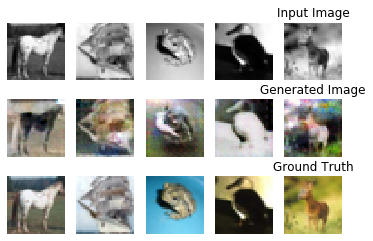

In [51]:
g_model_AtoB = load_all_models('_model_AtoB_%06d.h5' % (50000)) #load_all_models('_model_AtoB.h5')
Plot_Images(0, g_model_AtoB, trainA,trainB, 'AtoB', True)